<font size="+3.8">Scanpy single-cell pre-processing</font>  
<font size="+1.5"></font>  

sfrerich

Aim: Preprocess mouse brain single-cell data from Yang 2022 Nature  
Publication: https://www.nature.com/articles/s41586-021-04369-3

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import os
from datetime import date
from matplotlib.pyplot import rc_context

In [2]:
sc.settings.verbosity = 3

In [3]:
main_dir='/run/user/1000/gvfs/smb-share:server=138.245.4.35,share=bd-dichgans/SF' # Linux

In [4]:
main_dir='\\\isdsynnas.srv.med.uni-muenchen.de\BD-Dichgans\SF' # Win

# Load data

## Annotated 
Downloaded from: https://cells.ucsc.edu/?ds=brain-vasc-atlas

In [5]:
ad = sc.read_mtx(main_dir+"\\P6_vasc_scRNAseq\Yang2021\\ucsc_cellbrowser_data\\matrix.mtx.gz").transpose()

In [6]:
ad

AnnData object with n_obs × n_vars = 143793 × 23537

In [7]:
# Add var

In [8]:
var = pd.read_csv(main_dir+"\\P6_vasc_scRNAseq\Yang2021\\ucsc_cellbrowser_data\\features.tsv.gz", sep="\t", header=None)
all(var[0] == var[1])

True

In [9]:
var.index = var[0]
var.index.name = None

In [10]:
ad.var = var[[0]]
ad.var

,0
AL627309.1,AL627309.1
AL669831.5,AL669831.5
LINC00115,LINC00115
AL645608.1,AL645608.1
SAMD11,SAMD11
...,...
NCF4-AS1,NCF4-AS1
AL022316.1,AL022316.1
AL021392.1,AL021392.1
CU638689.4,CU638689.4


In [11]:
# Original cellnames

In [12]:
cellnames = pd.read_csv(main_dir+"\\P6_vasc_scRNAseq\Yang2021\\ucsc_cellbrowser_data\\barcodes.tsv.gz", sep="\t", header=None)
# used below to assert order

In [13]:
# Add metadata

In [14]:
meta = pd.read_csv(main_dir+"\\P6_vasc_scRNAseq\\Yang2021\\ucsc_cellbrowser_data\\meta.tsv", sep="\t")

In [15]:
ad.obs = meta
ad

AnnData object with n_obs × n_vars = 143793 × 23537
    obs: 'Cell', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Treat', 'Sample', 'Region', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.3', 'integrated_snn_res.0.35', 'Gender', 'Age', 'Batch', 'Sample_Region', 'Region_Number', 'Seurat_n', 'Seurat_Clusters', 'APOE4', 'APOE34', 'APOE_Number', 'Cell_Type'
    var: 0

In [16]:
ad.obs.columns

Index(['Cell', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Treat', 'Sample',
       'Region', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.3',
       'integrated_snn_res.0.35', 'Gender', 'Age', 'Batch', 'Sample_Region',
       'Region_Number', 'Seurat_n', 'Seurat_Clusters', 'APOE4', 'APOE34',
       'APOE_Number', 'Cell_Type'],
      dtype='object')

In [17]:
ad.obs.head(2)

,Cell,orig.ident,nCount_RNA,nFeature_RNA,Treat,Sample,Region,nCount_SCT,nFeature_SCT,integrated_snn_res.0.3,...,Age,Batch,Sample_Region,Region_Number,Seurat_n,Seurat_Clusters,APOE4,APOE34,APOE_Number,Cell_Type
0,AAACCCAAGAAGTGTT-1_1,HuVascAD,1450,1034,Control,C1,Hippocampus,1255,1034,4,...,58,2,C1_Hippocampus,0,5,4,yes,E4,1,Veinous
1,AAACCCAAGGCAGCTA-1_1,HuVascAD,1059,767,Control,C1,Hippocampus,1049,767,17,...,58,2,C1_Hippocampus,0,18,17,yes,E4,1,T cell


In [18]:
assert(all(ad.obs["Cell"] == cellnames[0]))

In [19]:
# add umap coords
umap = pd.read_csv(main_dir+"\\P6_vasc_scRNAseq\\Yang2021\\ucsc_cellbrowser_data\\UMAP.coords.tsv.gz", sep="\t", header=None)
ad.obsm['X_umap'] = umap[[1,2]].to_numpy()

In [20]:
# Exclude AD cases - keep healthy controls only

In [21]:
ad.obs["Sample"].unique()

array(['C1', 'C2', 'C3', 'C4', 'C5', 'C7', 'C8', 'C9', 'AD1', 'AD2',
       'AD3', 'AD4', 'AD5', 'AD6', 'AD7', 'AD8', 'AD9'], dtype=object)

In [22]:
controls = ['C1', 'C2', 'C3', 'C4', 'C5', 'C7', 'C8', 'C9']

In [23]:
ad = ad[ad.obs["Sample"].isin(controls)]

In [24]:
list(ad.obs["Cell_Type"].unique())

['Veinous',
 'T cell',
 'SMC',
 'Pericyte',
 'Capillary',
 'Arterial',
 'Oligo',
 'P. Fibro',
 'Ependymal',
 'Microglia/Mφ',
 'Astrocyte',
 'OPC',
 'M. Fibro',
 'Neuron']

D:\Programme\Anaconda\envs\squidpy\lib\site-packages\anndata\_core\anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
D:\Programme\Anaconda\envs\squidpy\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


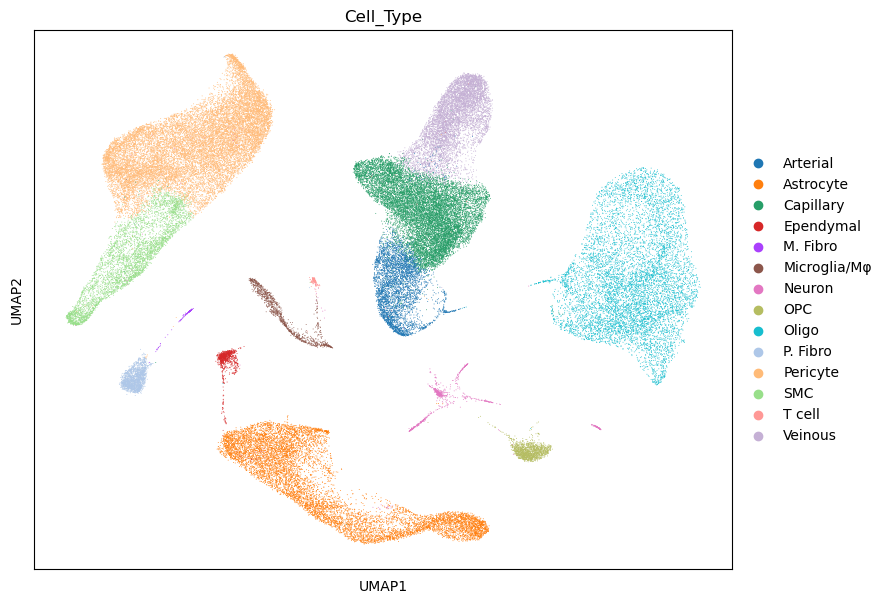

In [25]:
with rc_context({'figure.figsize': (9, 7)}):
    sc.pl.umap(ad, color=['Cell_Type'])

In [26]:
# Renaming
old_to_new = {'Arterial':'ECs_Arterial',
              'Astrocyte':'Astrocytes',
              'Capillary':'ECs_Capillary',
              'Ependymal':'Ependymal cells',
              'M. Fibro':'Fibroblasts',
              'Microglia/Mφ':'Microglia/Macrophages',
              'Neuron':'Neurons',
              'OPC':'OPCs',
              'P. Fibro':'Fibroblasts',
              'Pericyte':'Pericytes',
              'SMC':'SMCs',
              'T cell':'T cells',
              'Veinous':'ECs_Venous',
              'Oligo':'Oligos'}
ad.obs['clusters2'] = (ad.obs['Cell_Type'].map(old_to_new).astype('category'))

In [27]:
# Renaming
old_to_new = {'ECs_Arterial':'ECs',
              'Astrocytes':'Astrocytes',
              'ECs_Capillary':'ECs',
              'Ependymal cells':'Ependymal cells',
              'Fibroblasts':'Fibroblasts',
              'Microglia/Macrophages':'Microglia/Macrophages',
              'Neurons':'Neurons',
              'OPCs':'OPCs',
              'Fibroblasts':'Fibroblasts',
              'Pericytes':'Pericytes',
              'SMCs':'SMCs',
              'T cells':'T cells',
              'ECs_Venous':'ECs',
              'Oligos':'Oligos'}
ad.obs['clusters'] = (ad.obs['clusters2'].map(old_to_new).astype('category'))

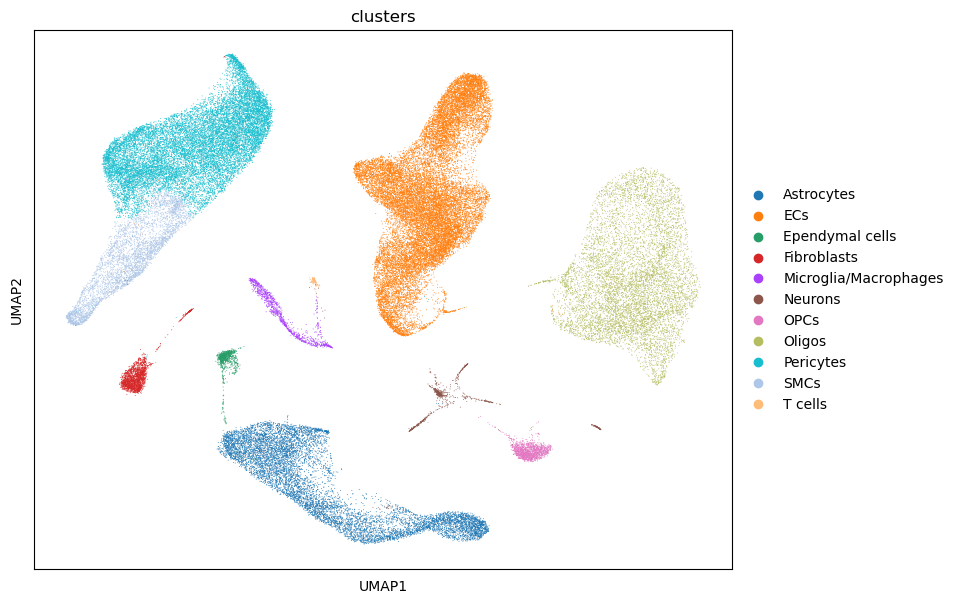

In [28]:
with rc_context({'figure.figsize': (9, 7)}):
    sc.pl.umap(ad, color=['clusters'])

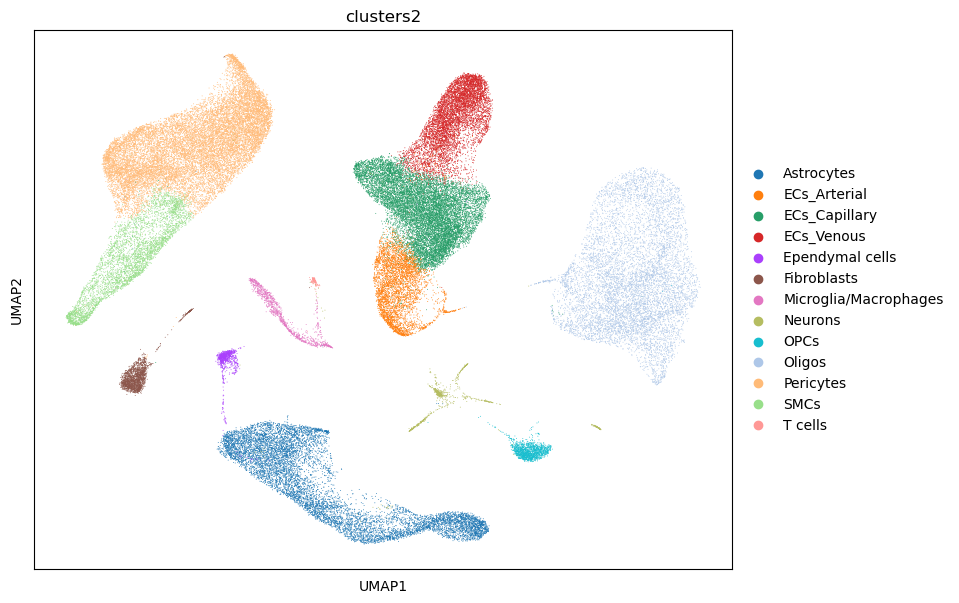

In [29]:
with rc_context({'figure.figsize': (9, 7)}):
    sc.pl.umap(ad, color=['clusters2'])

In [30]:
adata=ad

In [31]:
del ad

# Standard pipeline

Skip, because data is pre-analyzed.

Check if data is normalized:

In [47]:
adata.layers

Layers with keys: counts, normalized

In [33]:
adata.X

<72371x23537 sparse matrix of type '<class 'numpy.float32'>'
	with 50047119 stored elements in Compressed Sparse Row format>

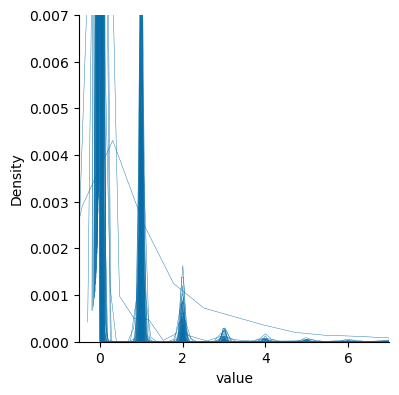

In [34]:
# show expression of 100 random genes (across all spots)
import random
import seaborn as sns
random_genes=random.sample(range(0, adata.X.shape[1]), 100)
adata_sub = adata[:,random_genes]
exp=pd.DataFrame(adata_sub.X.todense())
# plot
pl1=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3) # genes with 0 expression are excluded
pl1.set(xlim=(-0.5, 7),ylim=(0,0.007));
plt.show()

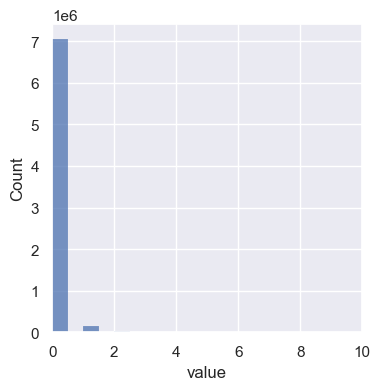

In [35]:
sns.set(rc={'figure.figsize':(4,4)})
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100))) # genes with 0 expression are excluded
pl.set(xlim=(0, 10));
sns.set_style("ticks")
plt.show()

Data is not normalized, therefore normalize and log-transform

In [36]:
adata.layers["counts"] = adata.X.copy() # save unnormalized raw RNA counts - retrieve via ad.X = ad.layers["counts"]

In [37]:
sc.pp.normalize_total(adata, inplace=True) # Normalize each spot by total counts over all genes, so that every spot has the same total count after normalization.

normalizing counts per cell
    finished (0:00:00)


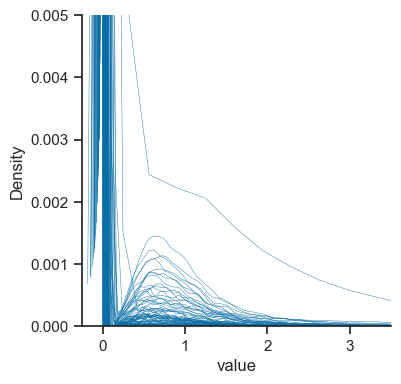

In [38]:
# show expression of 100 random genes (across all spots)
adata_sub = adata[:,random_genes]
exp=pd.DataFrame(adata_sub.X.todense())
# plot
pl=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3) # genes with 0 expression are excluded
pl.set(xlim=(-0.25, 3.5),ylim=(0,0.005))
plt.show()

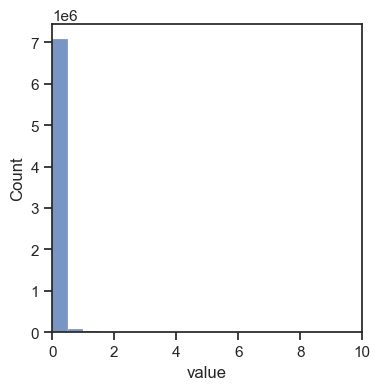

In [39]:
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100))) # genes with 0 expression are excluded
pl.set(xlim=(0, 10))
plt.show()

In [40]:
sc.pp.log1p(adata) # X = log(X + 1)

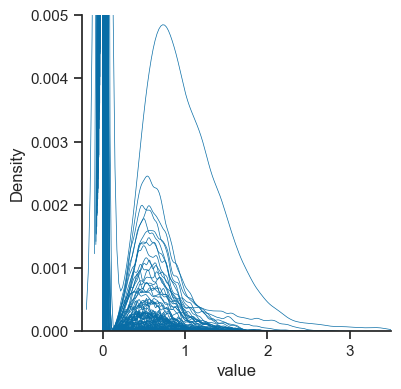

In [41]:
# show expression of 100 random genes (across all spots)
adata_sub = adata[:,random_genes]
exp=pd.DataFrame(adata_sub.X.todense())
# plot
pl=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.5) # genes with 0 expression are excluded
pl.set(xlim=(-0.25, 3.5),ylim=(0,0.005));
plt.show()

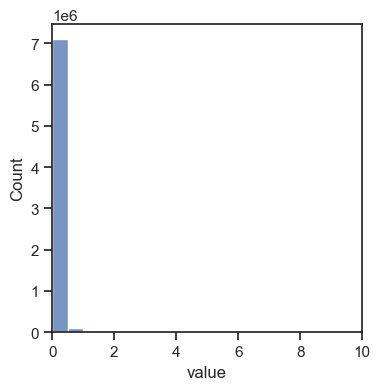

In [42]:
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100))); # genes with 0 expression are excluded
pl.set(xlim=(0, 10));
plt.show()

In [43]:
adata.layers["normalized"] = adata.X.copy() # save normalized + log-transformed (but unscaled) counts - retrieve via adata.X = adata.layers["normalized"]

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


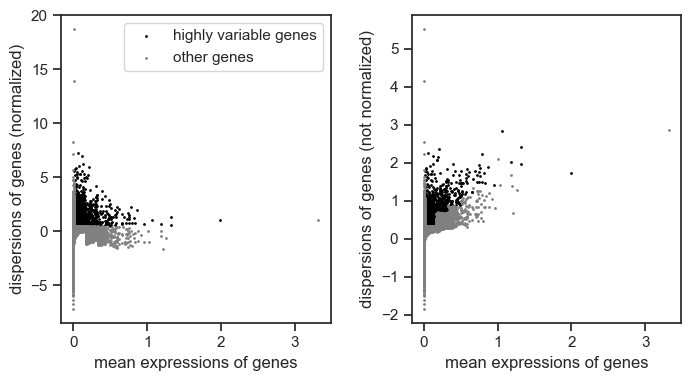

In [44]:
# Identify highly-variable genes
sc.pp.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata)

In [45]:
adata

AnnData object with n_obs × n_vars = 72371 × 23537
    obs: 'Cell', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Treat', 'Sample', 'Region', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.3', 'integrated_snn_res.0.35', 'Gender', 'Age', 'Batch', 'Sample_Region', 'Region_Number', 'Seurat_n', 'Seurat_Clusters', 'APOE4', 'APOE34', 'APOE_Number', 'Cell_Type', 'clusters2', 'clusters'
    var: 0, 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Cell_Type_colors', 'clusters_colors', 'clusters2_colors', 'log1p', 'hvg'
    obsm: 'X_umap'
    layers: 'counts', 'normalized'

In [46]:
adata.layers

Layers with keys: counts, normalized

# Vascular marker genes

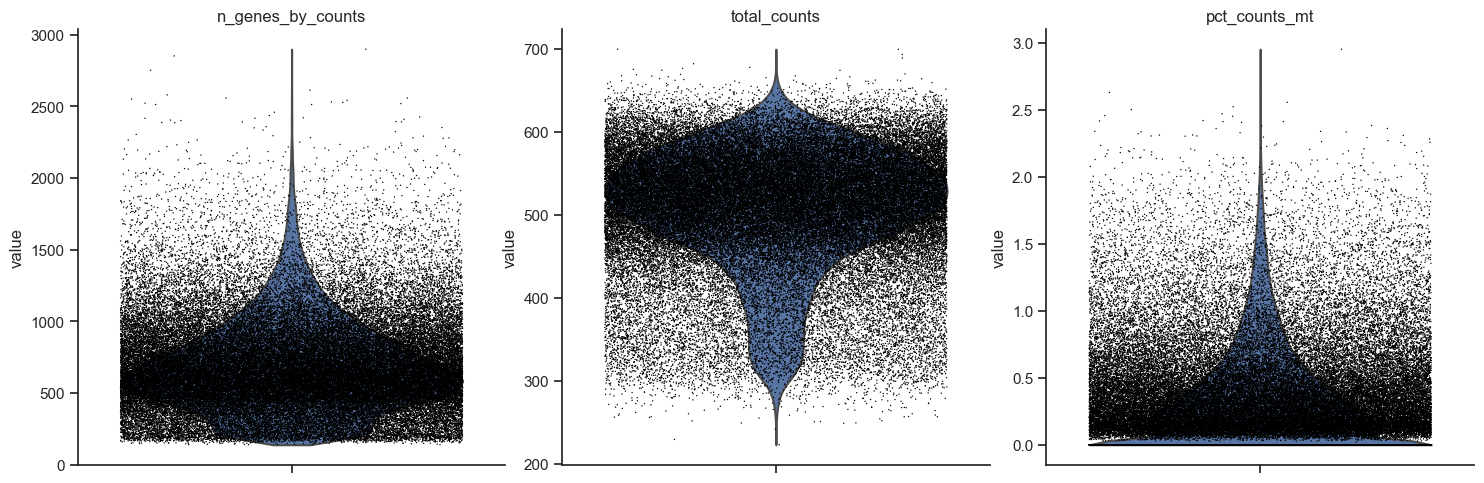

In [48]:
# Basic QC metrics
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],jitter=0.4, multi_panel=True)

In [72]:
sc.tl.rank_genes_groups(adata, 'clusters', method='wilcoxon', key_added='clusters')

ranking genes
    finished: added to `.uns['clusters']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:02:35)


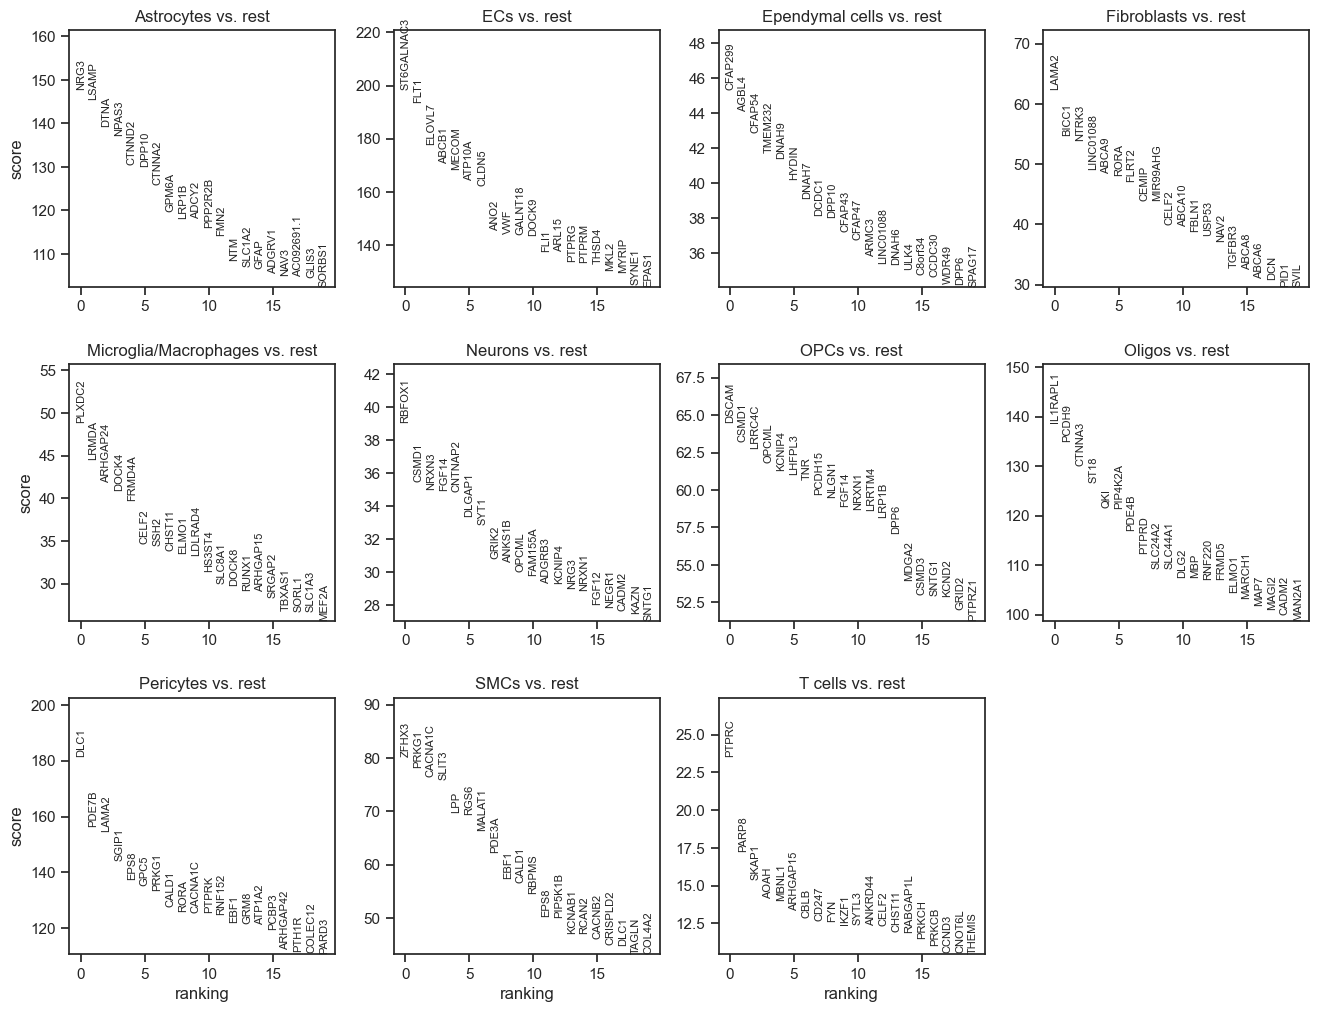

In [73]:
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, key='clusters')

Export DEG table

In [ ]:
sc.tl.rank_genes_groups(adata, 'clusters', method='wilcoxon')

ranking genes


In [82]:
# export DEG table
celltypes = adata.obs.clusters.unique().tolist()
merged_df = pd.DataFrame()
for group in celltypes:
    rank_df = rank_genes_groups_df(adata=adata, group=group, adj_pval_cutoff=None, log2fc_cutoff=None, sortby='zscore')
    merged_df = pd.concat([merged_df, rank_df])
    merged_df['reference'] = 'all other clusters'
merged_df.head(3)

divide by zero encountered in log10


,gene,log2FC,FC,pvals,pvals_adj,nlog10_pval_adj,zscore,group,reference
ST6GALNAC3,ST6GALNAC3,4.155408,17.819790,0.0,0.0,inf,198.513687,ECs,all other clusters
FLT1,FLT1,4.654848,25.191202,0.0,0.0,inf,193.377121,ECs,all other clusters
ELOVL7,ELOVL7,4.711992,26.209024,0.0,0.0,inf,177.873337,ECs,all other clusters


In [85]:
merged_df.group.unique().tolist()

['ECs',
 'T cells',
 'SMCs',
 'Pericytes',
 'Oligos',
 'Fibroblasts',
 'Ependymal cells',
 'Microglia/Macrophages',
 'Astrocytes',
 'OPCs',
 'Neurons']

In [84]:
# export as csv
merged_df.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\DEA\\'+ date.today().strftime("%Y%m%d")+'_DE_genes_Yang2022.csv',sep=';')

In [87]:
sc.tl.rank_genes_groups(adata, 'clusters2', method='wilcoxon', key_added='clusters2')

ranking genes
    finished: added to `.uns['clusters2']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:02:59)


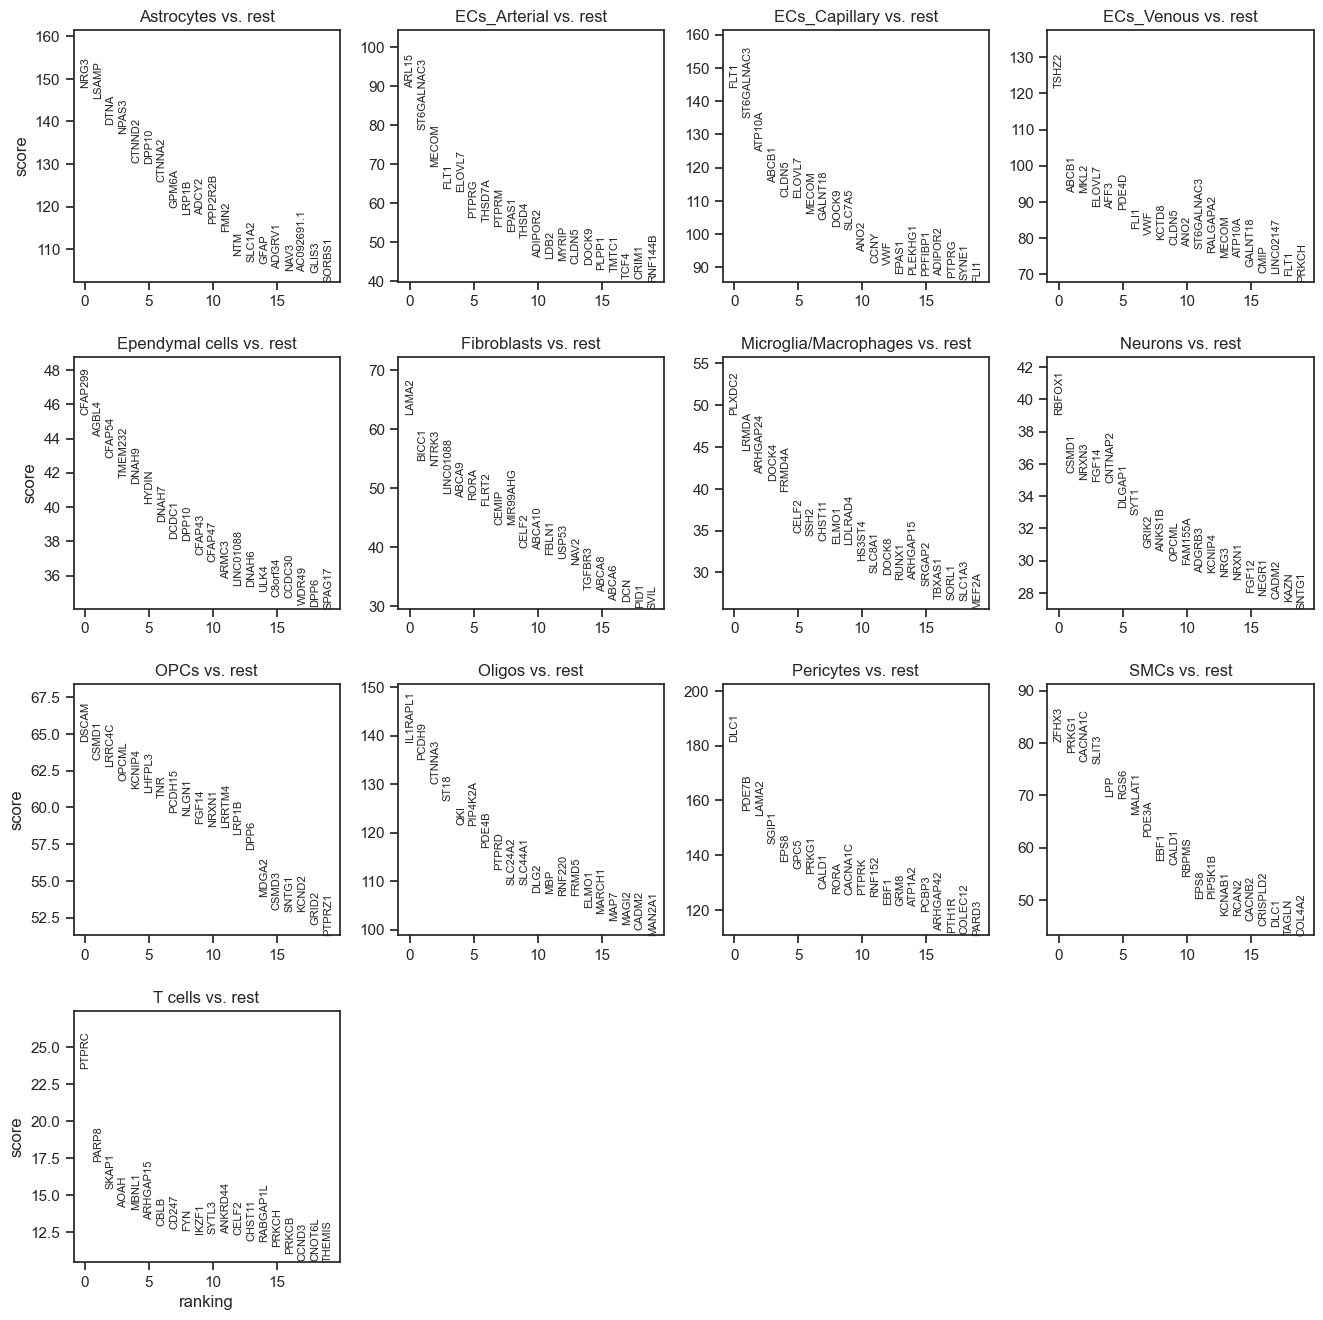

In [88]:
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, key='clusters2')

Export DEG table

In [92]:
sc.tl.rank_genes_groups(adata, 'clusters2', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:03:02)


In [93]:
celltypes = adata.obs.clusters2.unique().tolist()
merged_df = pd.DataFrame()
for group in celltypes:
    rank_df = rank_genes_groups_df(adata=adata, group=group, adj_pval_cutoff=None, log2fc_cutoff=None, sortby='zscore')
    merged_df = pd.concat([merged_df, rank_df])
    merged_df['reference'] = 'all other clusters'
merged_df.head(3)

divide by zero encountered in log10


,gene,log2FC,FC,pvals,pvals_adj,nlog10_pval_adj,zscore,group,reference
TSHZ2,TSHZ2,5.022112,32.494236,0.0,0.0,inf,121.440292,ECs_Venous,all other clusters
ABCB1,ABCB1,2.636389,6.217733,0.0,0.0,inf,92.651718,ECs_Venous,all other clusters
MKL2,MKL2,2.642808,6.245462,0.0,0.0,inf,92.392746,ECs_Venous,all other clusters


In [94]:
merged_df.group.unique().tolist()

['ECs_Venous',
 'T cells',
 'SMCs',
 'Pericytes',
 'ECs_Capillary',
 'ECs_Arterial',
 'Oligos',
 'Fibroblasts',
 'Ependymal cells',
 'Microglia/Macrophages',
 'Astrocytes',
 'OPCs',
 'Neurons']

In [95]:
# export as csv
merged_df.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\DEA\\'+ date.today().strftime("%Y%m%d")+'_DE_genes_Yang2022_incl_zonation.csv',sep=';')

# Focus on: Foxf2

In [49]:
gene="FOXF2"

## Plot

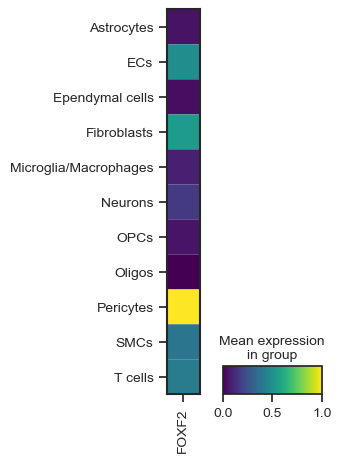

In [50]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

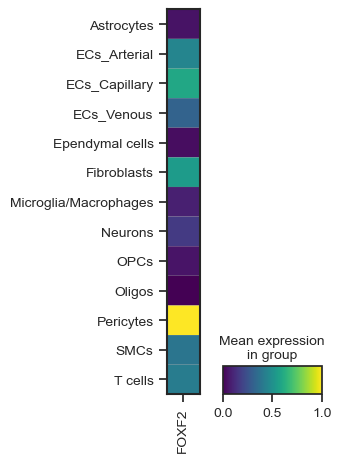

In [50]:
sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

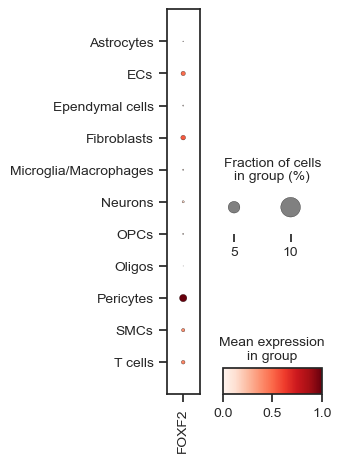

In [51]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

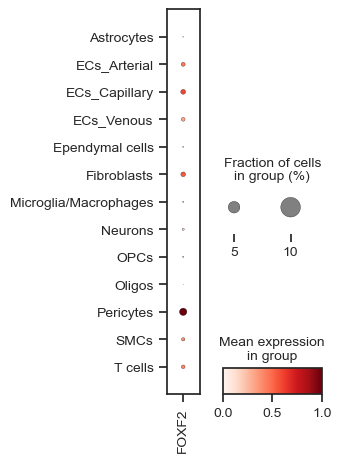

In [52]:
sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

## Excl zonation

In [53]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,0.046944
ECs,0.490284
Ependymal cells,0.034462
Fibroblasts,0.545060
Microglia/Macrophages,0.086930
Neurons,0.168198
OPCs,0.052711
Oligos,0.000000
Pericytes,1.000000


In [54]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,0.001307
ECs,0.013450
Ependymal cells,0.002260
Fibroblasts,0.014764
Microglia/Macrophages,0.002627
Neurons,0.005359
OPCs,0.002651
Oligos,0.000352
Pericytes,0.026878


In [55]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Yang2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.046944,0.001307,FOXF2,Yang2022,Human,9943
ECs,0.490284,0.013450,FOXF2,Yang2022,Human,24982
Ependymal cells,0.034462,0.002260,FOXF2,Yang2022,Human,885
Fibroblasts,0.545060,0.014764,FOXF2,Yang2022,Human,2032
Microglia/Macrophages,0.086930,0.002627,FOXF2,Yang2022,Human,1142
Neurons,0.168198,0.005359,FOXF2,Yang2022,Human,933
OPCs,0.052711,0.002651,FOXF2,Yang2022,Human,1509
Oligos,0.000000,0.000352,FOXF2,Yang2022,Human,8528
Pericytes,1.000000,0.026878,FOXF2,Yang2022,Human,17561


In [56]:
# export
name='Yang2022'

In [57]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Foxf2_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+name+'_normalized.csv',sep=';')

## Incl zonation

In [58]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']

In [59]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']

In [60]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Yang2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
Astrocytes,0.046944,0.001307,FOXF2,Yang2022,Human,9943
ECs_Arterial,0.455379,0.011815,FOXF2,Yang2022,Human,4486
ECs_Capillary,0.595828,0.015273,FOXF2,Yang2022,Human,13357
ECs_Venous,0.314746,0.011066,FOXF2,Yang2022,Human,7139
Ependymal cells,0.034462,0.002260,FOXF2,Yang2022,Human,885
Fibroblasts,0.545060,0.014764,FOXF2,Yang2022,Human,2032
Microglia/Macrophages,0.086930,0.002627,FOXF2,Yang2022,Human,1142
Neurons,0.168198,0.005359,FOXF2,Yang2022,Human,933
OPCs,0.052711,0.002651,FOXF2,Yang2022,Human,1509


In [61]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Foxf2_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+name+'_incl_zonation_normalized.csv',sep=';')

# Focus on: Other genes

## Foxo1

In [62]:
gene="FOXO1"

### Plot

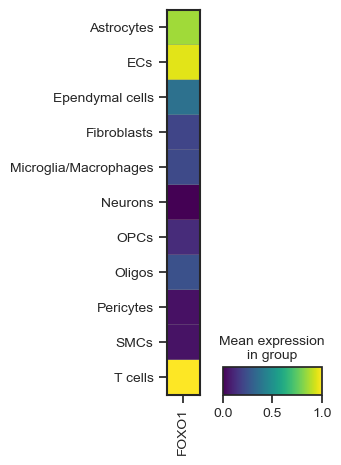

In [63]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

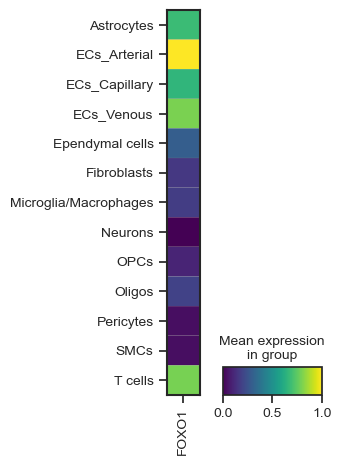

In [64]:
sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

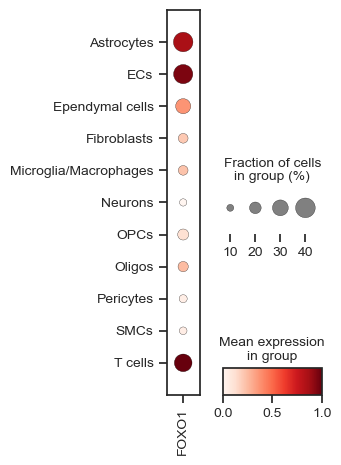

In [65]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

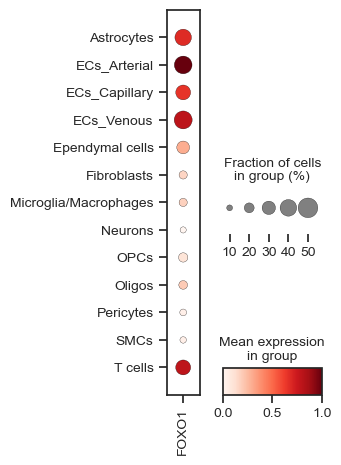

In [66]:
sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

### Excl zonation

In [67]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,0.859098
ECs,0.953482
Ependymal cells,0.369467
Fibroblasts,0.203891
Microglia/Macrophages,0.225142
Neurons,0.000000
OPCs,0.123307
Oligos,0.248102
Pericytes,0.046024


In [68]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,0.397063
ECs,0.389320
Ependymal cells,0.281356
Fibroblasts,0.156988
Microglia/Macrophages,0.155867
Neurons,0.107181
OPCs,0.185553
Oligos,0.169442
Pericytes,0.121633


In [69]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Yang2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.859098,0.397063,FOXO1,Yang2022,Human,9943
ECs,0.953482,0.389320,FOXO1,Yang2022,Human,24982
Ependymal cells,0.369467,0.281356,FOXO1,Yang2022,Human,885
Fibroblasts,0.203891,0.156988,FOXO1,Yang2022,Human,2032
Microglia/Macrophages,0.225142,0.155867,FOXO1,Yang2022,Human,1142
Neurons,0.000000,0.107181,FOXO1,Yang2022,Human,933
OPCs,0.123307,0.185553,FOXO1,Yang2022,Human,1509
Oligos,0.248102,0.169442,FOXO1,Yang2022,Human,8528
Pericytes,0.046024,0.121633,FOXO1,Yang2022,Human,17561


In [70]:
# export
name='Yang2022'

In [71]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_normalized.csv',sep=';')

### Incl zonation

In [72]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']

In [73]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']

In [74]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Yang2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
Astrocytes,0.682821,0.397063,FOXO1,Yang2022,Human,9943
ECs_Arterial,1.000000,0.435577,FOXO1,Yang2022,Human,4486
ECs_Capillary,0.653903,0.344538,FOXO1,Yang2022,Human,13357
ECs_Venous,0.800131,0.444040,FOXO1,Yang2022,Human,7139
Ependymal cells,0.293657,0.281356,FOXO1,Yang2022,Human,885
Fibroblasts,0.162055,0.156988,FOXO1,Yang2022,Human,2032
Microglia/Macrophages,0.178946,0.155867,FOXO1,Yang2022,Human,1142
Neurons,0.000000,0.107181,FOXO1,Yang2022,Human,933
OPCs,0.098006,0.185553,FOXO1,Yang2022,Human,1509


In [75]:
# export
name='Yang2022'

In [76]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation_normalized.csv',sep=';')

## Tek = Tie2

In [77]:
gene="TEK"

### Plot

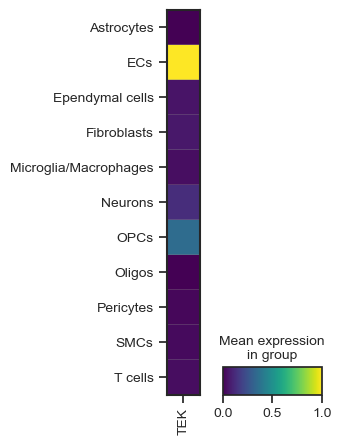

In [78]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

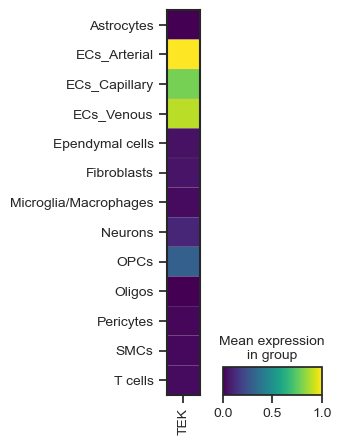

In [79]:
sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

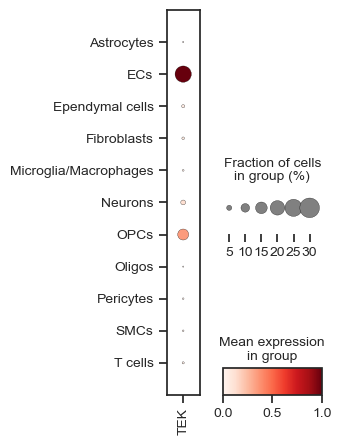

In [80]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

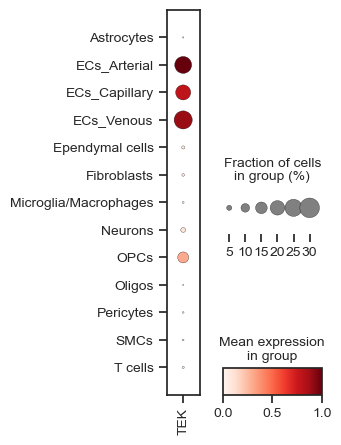

In [81]:
sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

### Excl zonation

In [82]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,0.000000
ECs,1.000000
Ependymal cells,0.052491
Fibroblasts,0.063011
Microglia/Macrophages,0.035701
Neurons,0.126694
OPCs,0.351236
Oligos,0.002713
Pericytes,0.018395


In [83]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,0.008247
ECs,0.233888
Ependymal cells,0.025989
Fibroblasts,0.020669
Microglia/Macrophages,0.012259
Neurons,0.046088
OPCs,0.138502
Oligos,0.007153
Pericytes,0.011104


In [84]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Yang2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.000000,0.008247,TEK,Yang2022,Human,9943
ECs,1.000000,0.233888,TEK,Yang2022,Human,24982
Ependymal cells,0.052491,0.025989,TEK,Yang2022,Human,885
Fibroblasts,0.063011,0.020669,TEK,Yang2022,Human,2032
Microglia/Macrophages,0.035701,0.012259,TEK,Yang2022,Human,1142
Neurons,0.126694,0.046088,TEK,Yang2022,Human,933
OPCs,0.351236,0.138502,TEK,Yang2022,Human,1509
Oligos,0.002713,0.007153,TEK,Yang2022,Human,8528
Pericytes,0.018395,0.011104,TEK,Yang2022,Human,17561


In [85]:
# export
name='Yang2022'

In [86]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_normalized.csv',sep=';')

### Incl zonation

In [87]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']

In [88]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']

In [89]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Yang2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
Astrocytes,0.000000,0.008247,TEK,Yang2022,Human,9943
ECs_Arterial,1.000000,0.245876,TEK,Yang2022,Human,4486
ECs_Capillary,0.791450,0.210826,TEK,Yang2022,Human,13357
ECs_Venous,0.897224,0.269506,TEK,Yang2022,Human,7139
Ependymal cells,0.045097,0.025989,TEK,Yang2022,Human,885
Fibroblasts,0.054135,0.020669,TEK,Yang2022,Human,2032
Microglia/Macrophages,0.030672,0.012259,TEK,Yang2022,Human,1142
Neurons,0.108846,0.046088,TEK,Yang2022,Human,933
OPCs,0.301756,0.138502,TEK,Yang2022,Human,1509


In [90]:
# export
name='Yang2022'

In [91]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation_normalized.csv',sep=';')

## Nos3 = eNOS

In [92]:
gene="NOS3"

### Plot

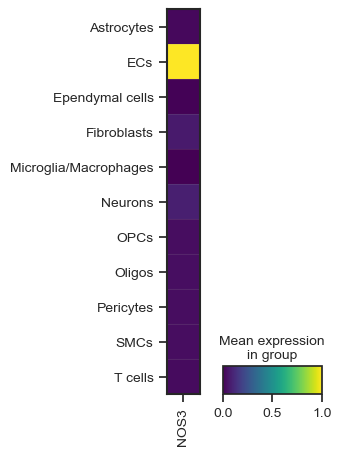

In [93]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

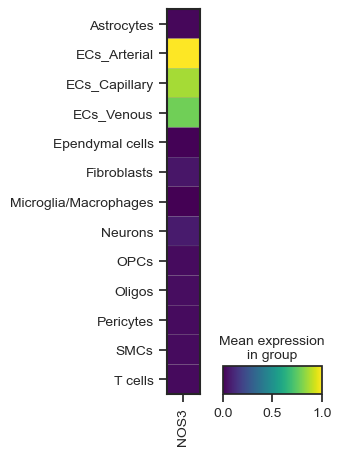

In [94]:
sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

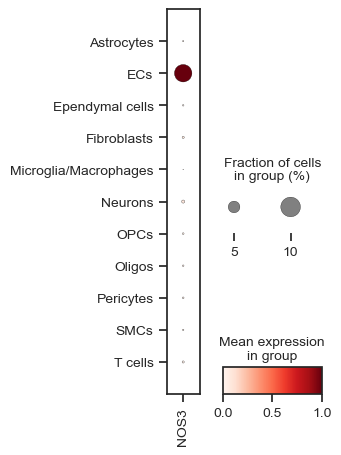

In [95]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

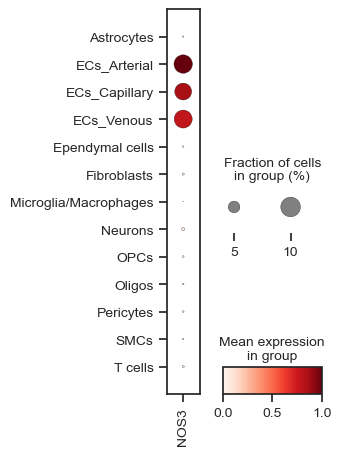

In [96]:
sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

### Excl zonation

In [97]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,0.021332
ECs,1.000000
Ependymal cells,0.006166
Fibroblasts,0.066724
Microglia/Macrophages,0.000000
Neurons,0.084413
OPCs,0.033535
Oligos,0.037134
Pericytes,0.034082


In [98]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,0.002816
ECs,0.085702
Ependymal cells,0.003390
Fibroblasts,0.005413
Microglia/Macrophages,0.000876
Neurons,0.008574
OPCs,0.003976
Oligos,0.003635
Pericytes,0.003929


In [99]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Yang2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.021332,0.002816,NOS3,Yang2022,Human,9943
ECs,1.000000,0.085702,NOS3,Yang2022,Human,24982
Ependymal cells,0.006166,0.003390,NOS3,Yang2022,Human,885
Fibroblasts,0.066724,0.005413,NOS3,Yang2022,Human,2032
Microglia/Macrophages,0.000000,0.000876,NOS3,Yang2022,Human,1142
Neurons,0.084413,0.008574,NOS3,Yang2022,Human,933
OPCs,0.033535,0.003976,NOS3,Yang2022,Human,1509
Oligos,0.037134,0.003635,NOS3,Yang2022,Human,8528
Pericytes,0.034082,0.003929,NOS3,Yang2022,Human,17561


In [100]:
# export
name='Yang2022'

In [101]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_normalized.csv',sep=';')

### Incl zonation

In [102]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']

In [103]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']

In [104]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Yang2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
Astrocytes,0.018469,0.002816,NOS3,Yang2022,Human,9943
ECs_Arterial,1.000000,0.091841,NOS3,Yang2022,Human,4486
ECs_Capillary,0.863957,0.081755,NOS3,Yang2022,Human,13357
ECs_Venous,0.784895,0.089228,NOS3,Yang2022,Human,7139
Ependymal cells,0.005338,0.003390,NOS3,Yang2022,Human,885
Fibroblasts,0.057769,0.005413,NOS3,Yang2022,Human,2032
Microglia/Macrophages,0.000000,0.000876,NOS3,Yang2022,Human,1142
Neurons,0.073084,0.008574,NOS3,Yang2022,Human,933
OPCs,0.029034,0.003976,NOS3,Yang2022,Human,1509


In [105]:
# export
name='Yang2022'

In [106]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation_normalized.csv',sep=';')

## HTRA1

In [51]:
gene="HTRA1"

### Plot

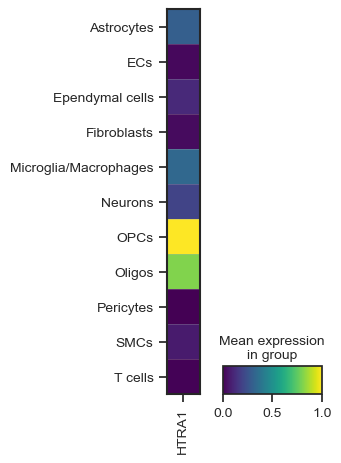

In [52]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

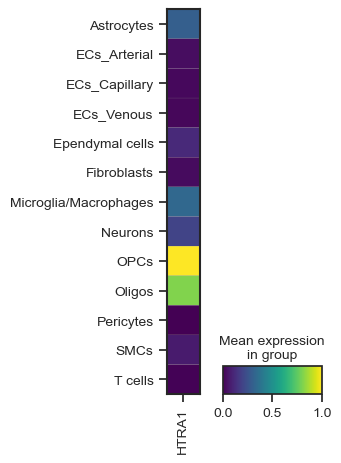

In [53]:
sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

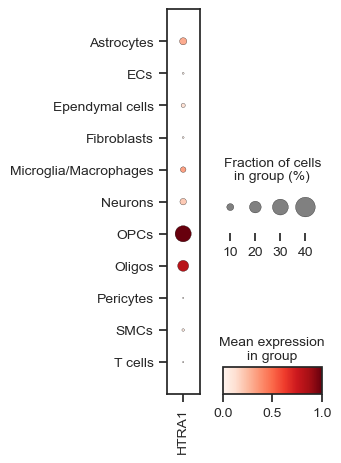

In [54]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

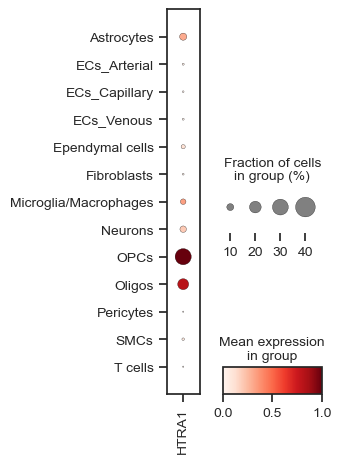

In [55]:
sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

### Excl zonation

In [56]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,0.299464
ECs,0.022093
Ependymal cells,0.116547
Fibroblasts,0.029907
Microglia/Macrophages,0.332597
Neurons,0.200246
OPCs,1.000000
Oligos,0.810460
Pericytes,0.000000


In [57]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,0.104093
ECs,0.017092
Ependymal cells,0.050847
Fibroblasts,0.016732
Microglia/Macrophages,0.074431
Neurons,0.091104
OPCs,0.308151
Oligos,0.184217
Pericytes,0.010421


In [58]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Yang2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.299464,0.104093,HTRA1,Yang2022,Human,9943
ECs,0.022093,0.017092,HTRA1,Yang2022,Human,24982
Ependymal cells,0.116547,0.050847,HTRA1,Yang2022,Human,885
Fibroblasts,0.029907,0.016732,HTRA1,Yang2022,Human,2032
Microglia/Macrophages,0.332597,0.074431,HTRA1,Yang2022,Human,1142
Neurons,0.200246,0.091104,HTRA1,Yang2022,Human,933
OPCs,1.000000,0.308151,HTRA1,Yang2022,Human,1509
Oligos,0.810460,0.184217,HTRA1,Yang2022,Human,8528
Pericytes,0.000000,0.010421,HTRA1,Yang2022,Human,17561


In [59]:
# export
name='Yang2022'

In [60]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_normalized.csv',sep=';')

### Incl zonation

In [61]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']

In [62]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']

In [63]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Yang2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
Astrocytes,0.299464,0.104093,HTRA1,Yang2022,Human,9943
ECs_Arterial,0.033481,0.019394,HTRA1,Yang2022,Human,4486
ECs_Capillary,0.019797,0.015497,HTRA1,Yang2022,Human,13357
ECs_Venous,0.019234,0.018630,HTRA1,Yang2022,Human,7139
Ependymal cells,0.116547,0.050847,HTRA1,Yang2022,Human,885
Fibroblasts,0.029907,0.016732,HTRA1,Yang2022,Human,2032
Microglia/Macrophages,0.332597,0.074431,HTRA1,Yang2022,Human,1142
Neurons,0.200246,0.091104,HTRA1,Yang2022,Human,933
OPCs,1.000000,0.308151,HTRA1,Yang2022,Human,1509


In [64]:
# export
name='Yang2022'

In [65]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation_normalized.csv',sep=';')

## EGFL8

In [76]:
gene="EGFL8"

### Plot

In [77]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

KeyError: "Could not find keys '['EGFL8']' in columns of `adata.obs` or in adata.var_names."

# Session Info

In [107]:
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.2.0
asciitree                   NA
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.5
cffi                        1.15.1
cloudpickle                 2.0.0
colorama                    0.4.5
cycler                      0.10.0
cython_runtime              NA
dask                        2022.05.0
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.3
fasteners                   0.17.3
fsspec                      2022.3.0
h5py                        3.6.0
hypergeom_ufunc             NA
igraph                      0.9.10
ipykernel                   6.15.2
ipython_genutils            0.2.0
ipywidgets                  7.7.0
jedi                        0.18.1
jinja2 